<a href="https://colab.research.google.com/github/ivarela28/Deep-Learning-with-Python/blob/master/tokenizing_embedding_text_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

In [ ]:
max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6643 - acc: 0.6377 - val_loss: 0.6070 - val_acc: 0.7020
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5321 - acc: 0.7552 - val_loss: 0.5210 - val_acc: 0.7344
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4571 - acc: 0.7885 - val_loss: 0.4989 - val_acc: 0.7484
Epoch 4/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4208 - acc: 0.8079 - val_loss: 0.4928 - val_acc: 0.7568
Epoch 5/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3960 - acc: 0.8207 - val_loss: 0.4947 - val_acc: 0.7572
Epoch 6/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3762 - acc: 0.8316 - val_loss: 0.4966 - val_acc: 0.7574
Epoch 7/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3578 - acc: 0.8435 - val_loss: 0.5011 - val_acc: 0.7566
Epoch 8/10
625/625 [==============================] - 1s 1ms/step - loss: 0.

In [1]:
!unzip /content/aclImdb.zip

unzip:  cannot find or open /content/aclImdb.zip, /content/aclImdb.zip.zip or /content/aclImdb.zip.ZIP.


In [1]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/aclImdb.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [2]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/glove.6B.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
import os

imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor: ', data.shape)
print('Shape of labels tensor: ', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor:  (25000, 100)
Shape of labels tensor:  (25000,)


In [5]:
glove_dir = '/content'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [6]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [9]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 5s 133ms/step - loss: 1.9101 - acc: 0.4900 - val_loss: 0.6925 - val_acc: 0.5037
Epoch 2/10
7/7 [==============================] - 1s 109ms/step - loss: 0.6410 - acc: 0.6150 - val_loss: 0.7315 - val_acc: 0.5042
Epoch 3/10
7/7 [==============================] - 1s 96ms/step - loss: 0.5961 - acc: 0.6250 - val_loss: 0.6914 - val_acc: 0.5186
Epoch 4/10
7/7 [==============================] - 1s 109ms/step - loss: 0.5770 - acc: 0.6750 - val_loss: 0.7026 - val_acc: 0.5079
Epoch 5/10
7/7 [==============================] - 1s 95ms/step - loss: 0.4750 - acc: 0.7200 - val_loss: 0.7370 - val_acc: 0.5108
Epoch 6/10
7/7 [==============================] - 1s 94ms/step - loss: 0.4566 - acc: 0.6850 - val_loss: 0.6868 - val_acc: 0.5600
Epoch 7/10
7/7 [==============================] - 1s 110ms/step - loss: 0.4060 - acc: 0.8150 - val_loss: 1.2097 - val_acc: 0.5038
Epoch 8/10
7/7 [==============================] - 1s 96ms/step - loss: 0.4507 - acc: 0.7750 -

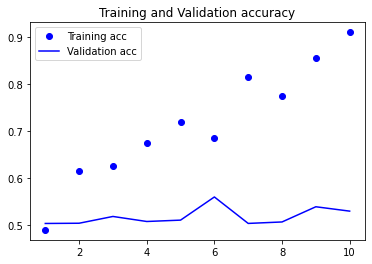

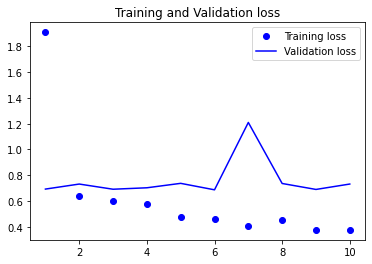

In [10]:
import matplotlib.pyplot as plt

def plot_loss_acc(stats):
  acc = stats.history['acc']
  val_acc = stats.history['val_acc']
  loss = stats.history['loss']
  val_loss = stats.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and Validation accuracy')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()

  plt.show()

plot_loss_acc(history)

In [16]:
model.save_weights('pre_trained_glove_model.h5')

In [13]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)
  for fname in sorted(os.listdir(dir_name)):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [17]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.7442 - acc: 0.5259


[0.7441956400871277, 0.525879979133606]